### Libraries

In [1]:
#!pip install transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## VGG

####Initializing

In [ ]:
from torchvision.models import vgg16
transform = transforms.Compose([
    transforms.Resize((224,224)),  # VGG models expect 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torchvision.datasets import ImageFolder

train_path = "/content/drive/MyDrive/Resubmission/TrainSet"
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

validation_path = "/content/drive/MyDrive/Resubmission/ValidationSet"
validation_dataset = ImageFolder(root=validation_path, transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)

test_path = "/content/drive/MyDrive/Resubmission/TestSet"
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

####Combination 1

Training/Validation Results

Epoch 1, Train Loss: 1.0886, Train Accuracy: 37.54%, Validation Loss: 1.0608, Validation Accuracy: 43.56%
Elapsed Time: 55.15 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.0729, Train Accuracy: 41.14%, Validation Loss: 1.0442, Validation Accuracy: 49.75%
Elapsed Time: 54.36 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.0597, Train Accuracy: 40.30%, Validation Loss: 1.0264, Validation Accuracy: 53.47%
Elapsed Time: 54.96 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.0469, Train Accuracy: 41.98%, Validation Loss: 1.0074, Validation Accuracy: 55.69%
Elapsed Time: 54.73 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.0299, Train Accuracy: 44.03%, Validation Loss: 0.9892, Validation Accuracy: 57.67%
Elapsed Time: 54.42 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.0113, Train Accuracy: 46.17%, Validation Loss: 

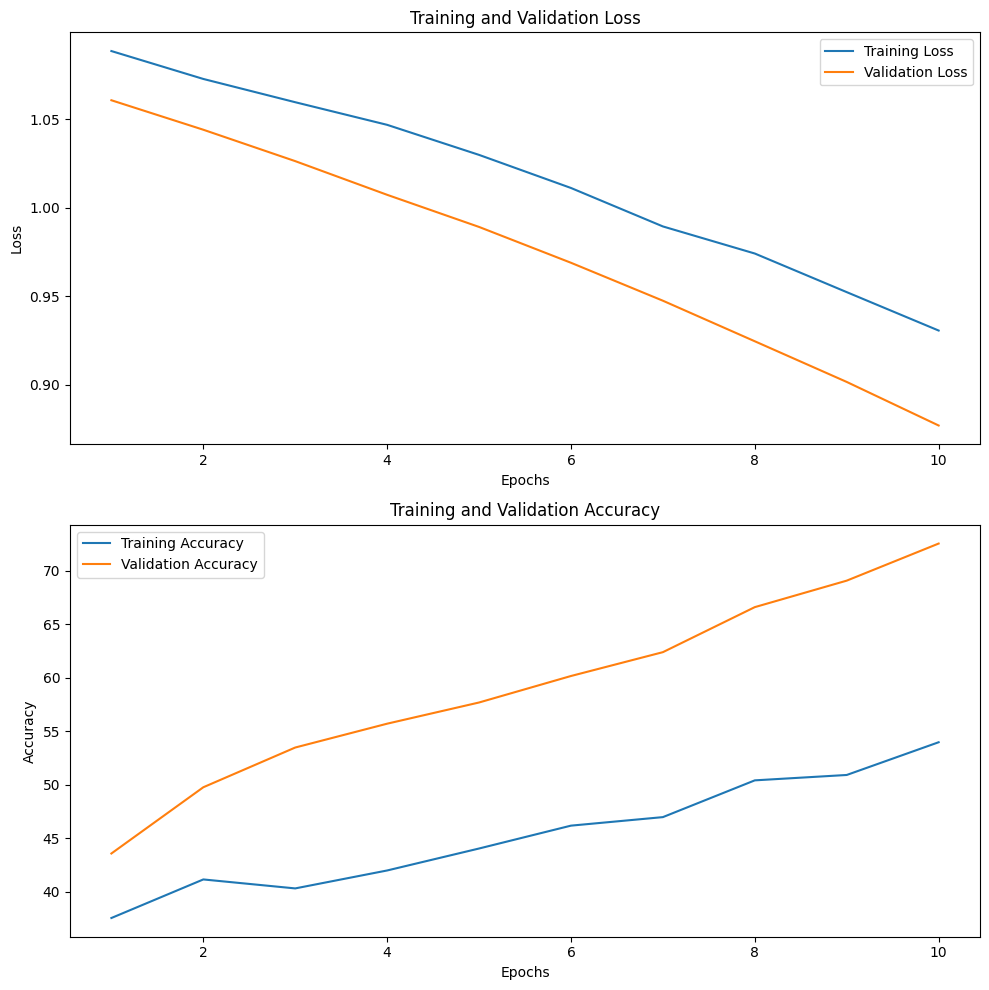

In [ ]:
model = vgg16(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.2))
model = model.to(device) # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.8515, Test Accuracy: 75.45%
Precision: 0.8147, Recall: 0.7571, F1 Score: 0.7403
Elapsed Time: 11.82 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      343    12      4
Lion          37   333      5
Tiger        185    29    160


####Combination 2

Training/Validation Results

Epoch 1, Train Loss: 1.2300, Train Accuracy: 34.81%, Validation Loss: 1.0839, Validation Accuracy: 40.10%
Elapsed Time: 435.97 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.2282, Train Accuracy: 36.20%, Validation Loss: 1.0829, Validation Accuracy: 40.10%
Elapsed Time: 52.81 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.2336, Train Accuracy: 36.45%, Validation Loss: 1.0818, Validation Accuracy: 40.59%
Elapsed Time: 52.54 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.2371, Train Accuracy: 35.19%, Validation Loss: 1.0808, Validation Accuracy: 40.84%
Elapsed Time: 52.72 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.2135, Train Accuracy: 36.07%, Validation Loss: 1.0799, Validation Accuracy: 41.34%
Elapsed Time: 52.35 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.2309, Train Accuracy: 34.73%, Validation Loss:

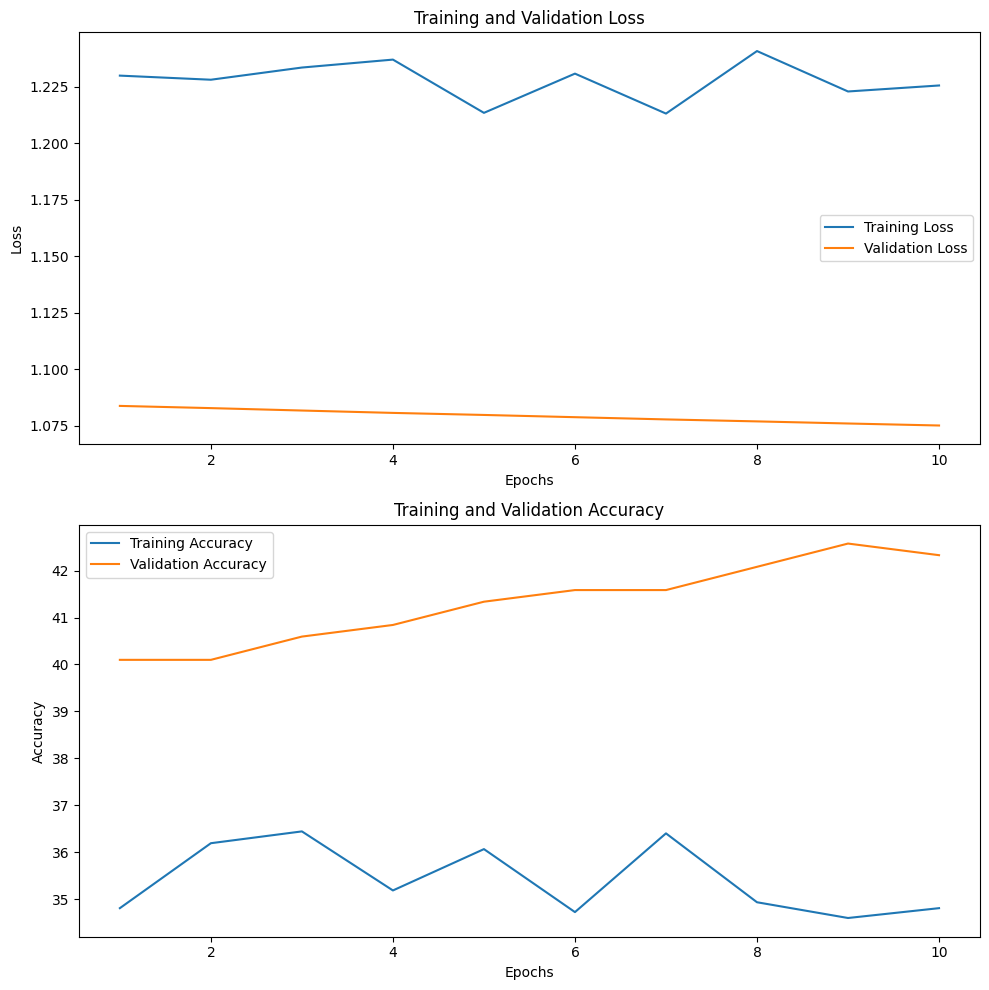

In [ ]:
model = vgg16(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.7))
model = model.to(device) # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000001, weight_decay=0.01)

from torch.nn.utils import clip_grad_norm_
clip_value = 900.0

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 1.0736, Test Accuracy: 41.88%
Precision: 0.3937, Recall: 0.4201, F1 Score: 0.3520
Elapsed Time: 15.74 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      193   157      9
Lion         101   259     15
Tiger        148   214     12


####Combination 3

Training/Validation Results

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.1901, Train Accuracy: 34.52%, Validation Loss: 1.1291, Validation Accuracy: 34.16%
Elapsed Time: 54.44 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1719, Train Accuracy: 34.60%, Validation Loss: 1.1054, Validation Accuracy: 34.90%
Elapsed Time: 54.06 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.1418, Train Accuracy: 36.45%, Validation Loss: 1.0846, Validation Accuracy: 36.14%
Elapsed Time: 53.56 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.1242, Train Accuracy: 37.12%, Validation Loss: 1.0665, Validation Accuracy: 38.61%
Elapsed Time: 53.88 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.0984, Train Accuracy: 38.50%, Validation Loss: 1.0499, Validation Accuracy: 39.60%
Elapsed Time: 53.26 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.0723, Train Accuracy: 39.46%, Validation Loss: 

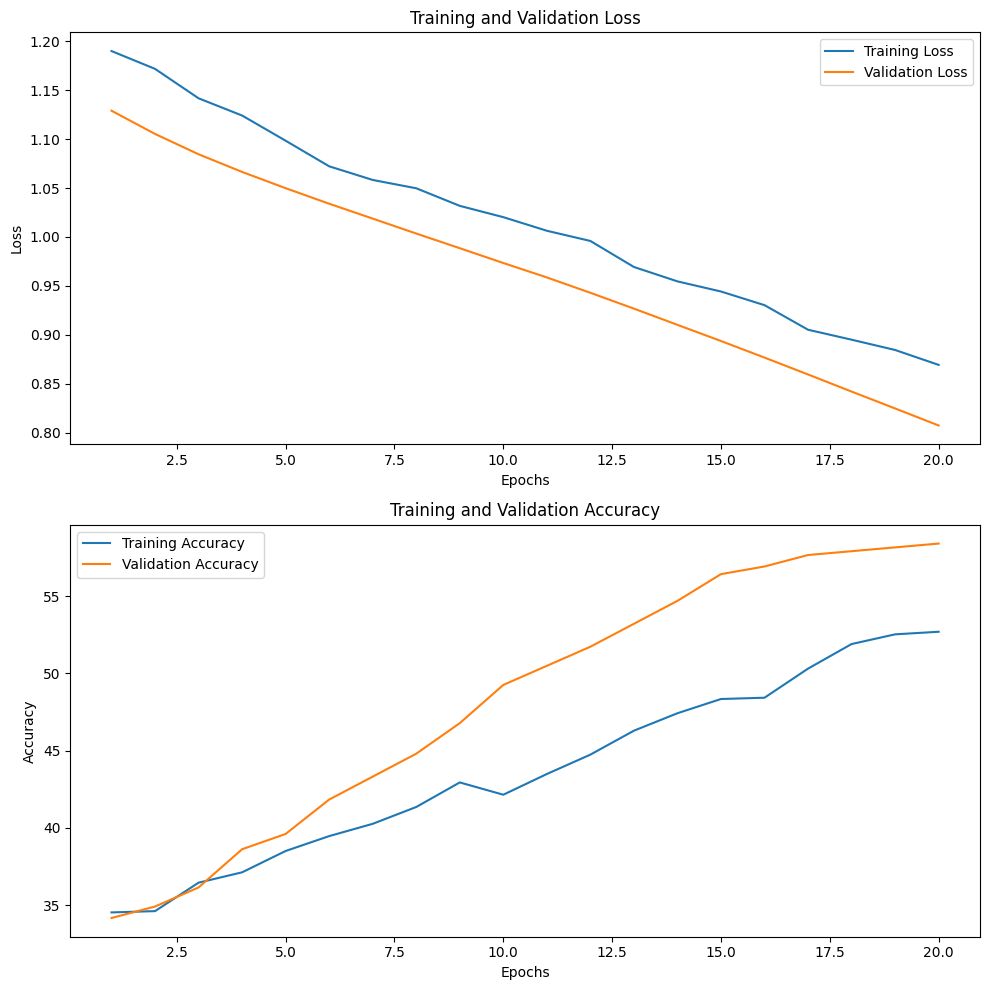

In [ ]:
model = vgg16(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.2))
model = model.to(device) # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.7897, Test Accuracy: 61.73%
Precision: 0.7854, Recall: 0.6222, F1 Score: 0.5122
Elapsed Time: 11.20 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      357     2      0
Lion          51   324      0
Tiger        324    47      3


####Combination 4

Training/Validation Results

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.2236, Train Accuracy: 28.11%, Validation Loss: 1.1753, Validation Accuracy: 26.24%
Elapsed Time: 53.21 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1899, Train Accuracy: 31.04%, Validation Loss: 1.1474, Validation Accuracy: 27.97%
Elapsed Time: 53.14 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.1528, Train Accuracy: 33.18%, Validation Loss: 1.1225, Validation Accuracy: 30.45%
Elapsed Time: 53.25 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.1349, Train Accuracy: 33.31%, Validation Loss: 1.0994, Validation Accuracy: 34.65%
Elapsed Time: 53.06 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.1145, Train Accuracy: 35.40%, Validation Loss: 1.0778, Validation Accuracy: 38.37%
Elapsed Time: 53.27 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.0921, Train Accuracy: 39.04%, Validation Loss: 

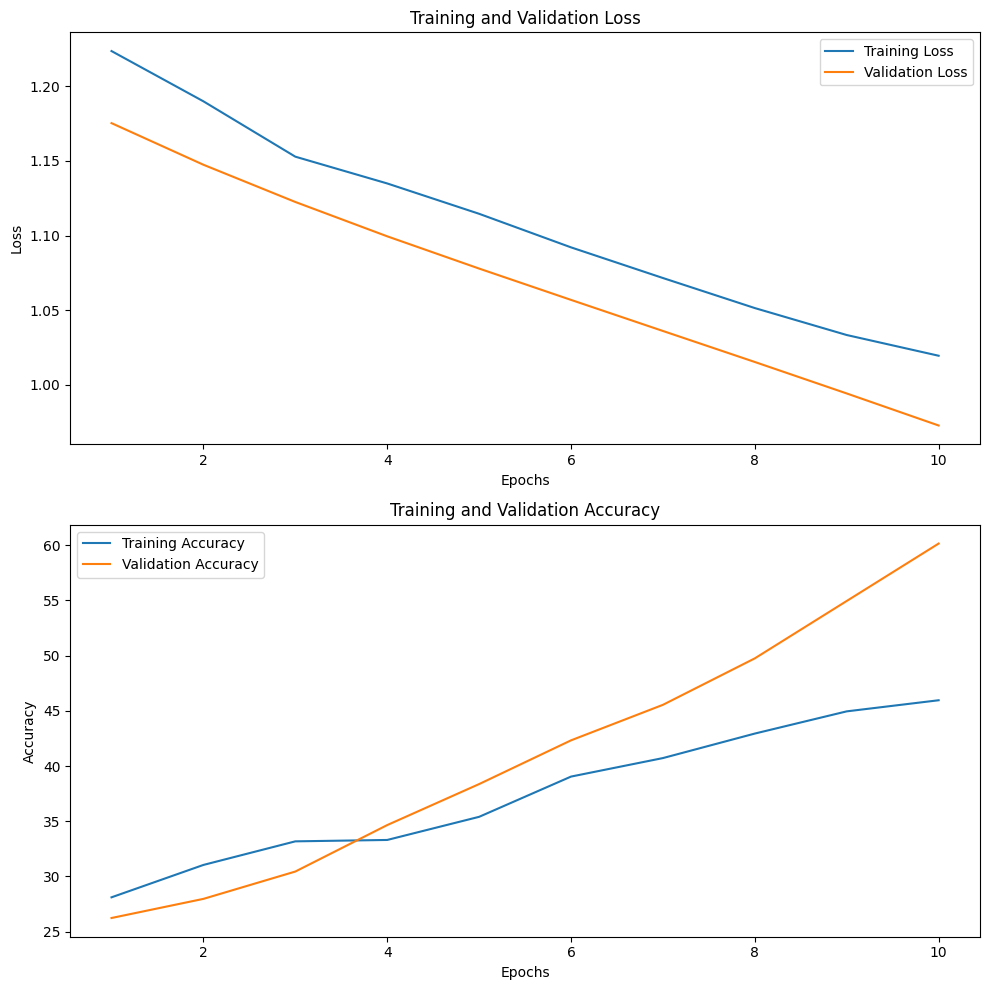

In [ ]:
model = vgg16(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.1))
model = model.to(device) # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 10000.0

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.9545, Test Accuracy: 59.39%
Precision: 0.5840, Recall: 0.5926, F1 Score: 0.5644
Elapsed Time: 11.28 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      188    98     73
Lion          13   355      7
Tiger        167    92    115


## GoogLeNet

####Initializing

In [3]:
from torchvision.models import googlenet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
from torchvision.datasets import ImageFolder

train_path = "/content/drive/MyDrive/Resubmission/TrainSet"
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

validation_path = "/content/drive/MyDrive/Resubmission/ValidationSet"
validation_dataset = ImageFolder(root=validation_path, transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)

test_path = "/content/drive/MyDrive/Resubmission/TestSet"
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

#### Combination 1

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.1188, Train Accuracy: 32.68%, Validation Loss: 1.1060, Validation Accuracy: 34.41%
Elapsed Time: 28.44 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1156, Train Accuracy: 31.92%, Validation Loss: 1.1039, Validation Accuracy: 34.65%
Elapsed Time: 25.73 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.1145, Train Accuracy: 31.92%, Validation Loss: 1.1006, Validation Accuracy: 34.90%
Elapsed Time: 24.69 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.1106, Train Accuracy: 34.27%, Validation Loss: 1.0982, Validation Accuracy: 34.65%
Elapsed Time: 24.60 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.1110, Train Accuracy: 32.97%, Validation Loss: 1.0982, Validation Accuracy: 34.65%
Elapsed Time: 25.66 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.1086, Train Accuracy: 33.26%, Validation Loss: 

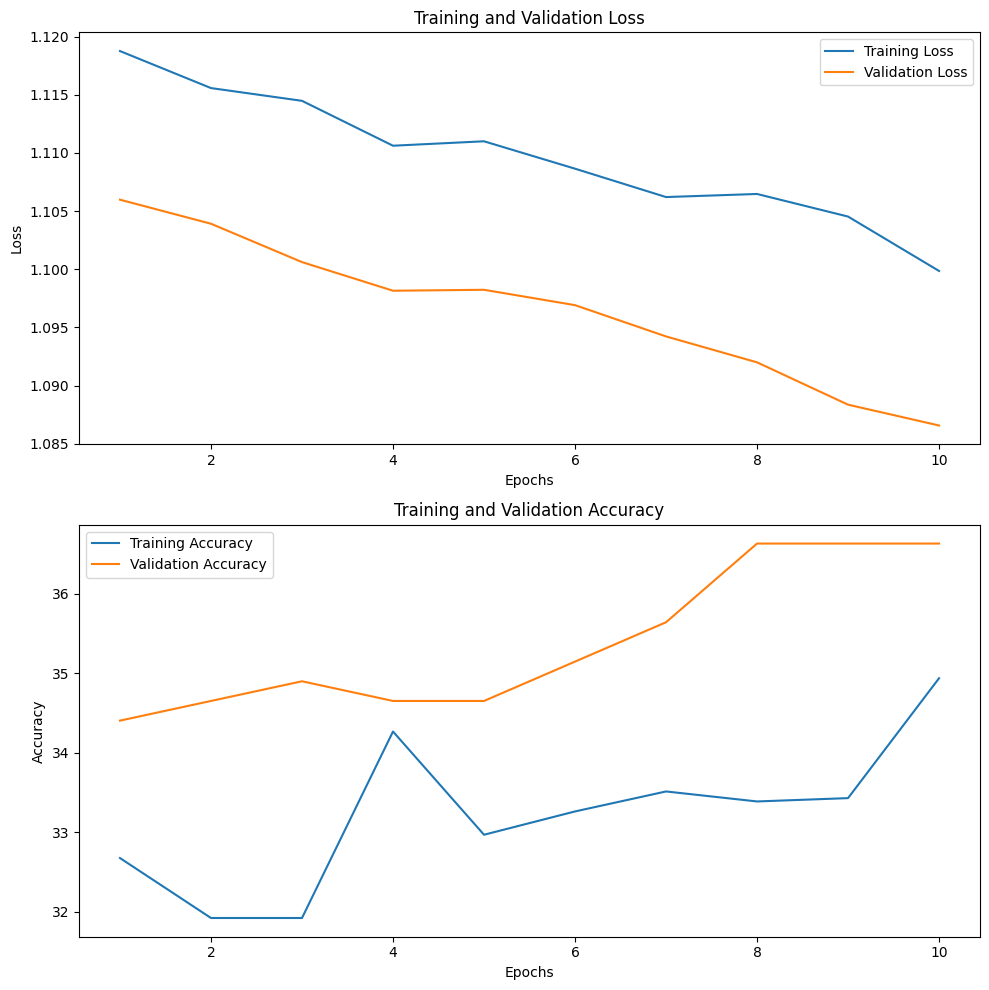

In [ ]:
model = googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.2))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 1.0903, Test Accuracy: 38.00%
Precision: 0.4094, Recall: 0.3774, F1 Score: 0.2919
Elapsed Time: 8.51 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah       61    19    279
Lion          94    24    257
Tiger         35     3    336


#### Combination 2

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.6681, Train Accuracy: 64.14%, Validation Loss: 0.1791, Validation Accuracy: 97.77%
Elapsed Time: 753.58 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.4942, Train Accuracy: 71.05%, Validation Loss: 0.1357, Validation Accuracy: 97.77%
Elapsed Time: 775.04 seconds
--------------------------------------------------



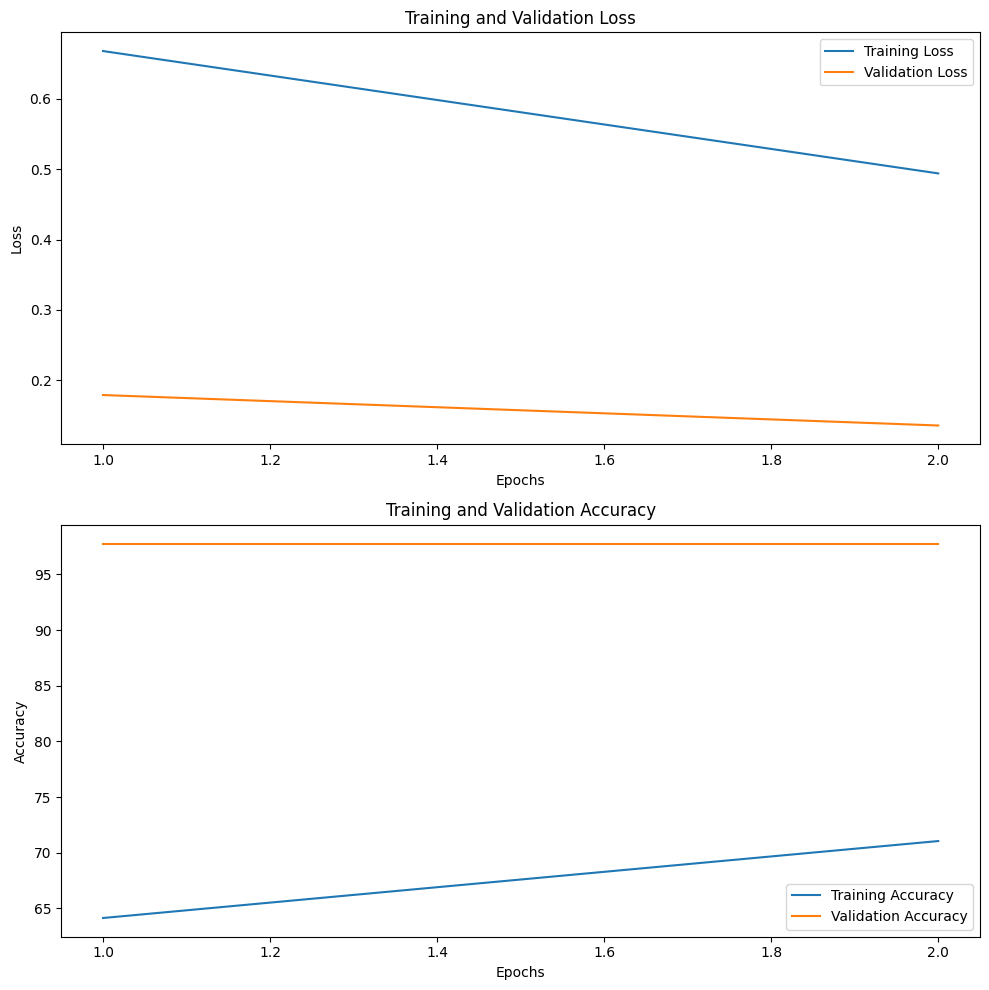

In [7]:
model = googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.4))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.003)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [9]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.1228, Test Accuracy: 97.92%
Precision: 0.9796, Recall: 0.9790, F1 Score: 0.9792
Elapsed Time: 152.57 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      346     9      4
Lion           1   369      5
Tiger          2     2    370


#### Combination 3

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.8713, Train Accuracy: 49.77%, Validation Loss: 0.4142, Validation Accuracy: 97.03%
Elapsed Time: 754.54 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.8077, Train Accuracy: 51.61%, Validation Loss: 0.3526, Validation Accuracy: 98.02%
Elapsed Time: 744.84 seconds
--------------------------------------------------



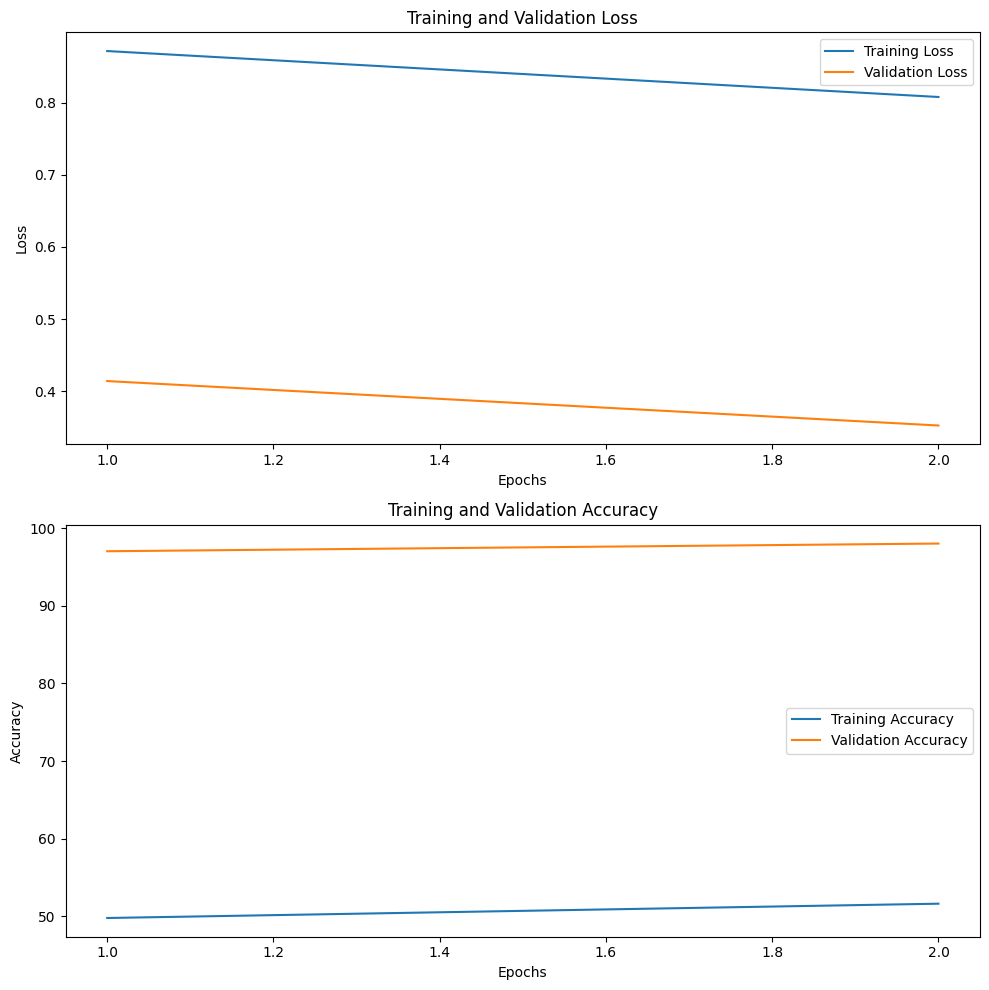

In [10]:
model = googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.7))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [11]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.3334, Test Accuracy: 97.92%
Precision: 0.9792, Recall: 0.9792, F1 Score: 0.9792
Elapsed Time: 170.40 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      351     2      6
Lion           5   369      1
Tiger          4     5    365


#### Combination 4

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.0920, Train Accuracy: 35.06%, Validation Loss: 1.0986, Validation Accuracy: 32.67%
Elapsed Time: 729.05 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.0987, Train Accuracy: 33.72%, Validation Loss: 1.0991, Validation Accuracy: 31.93%
Elapsed Time: 1651.36 seconds
--------------------------------------------------



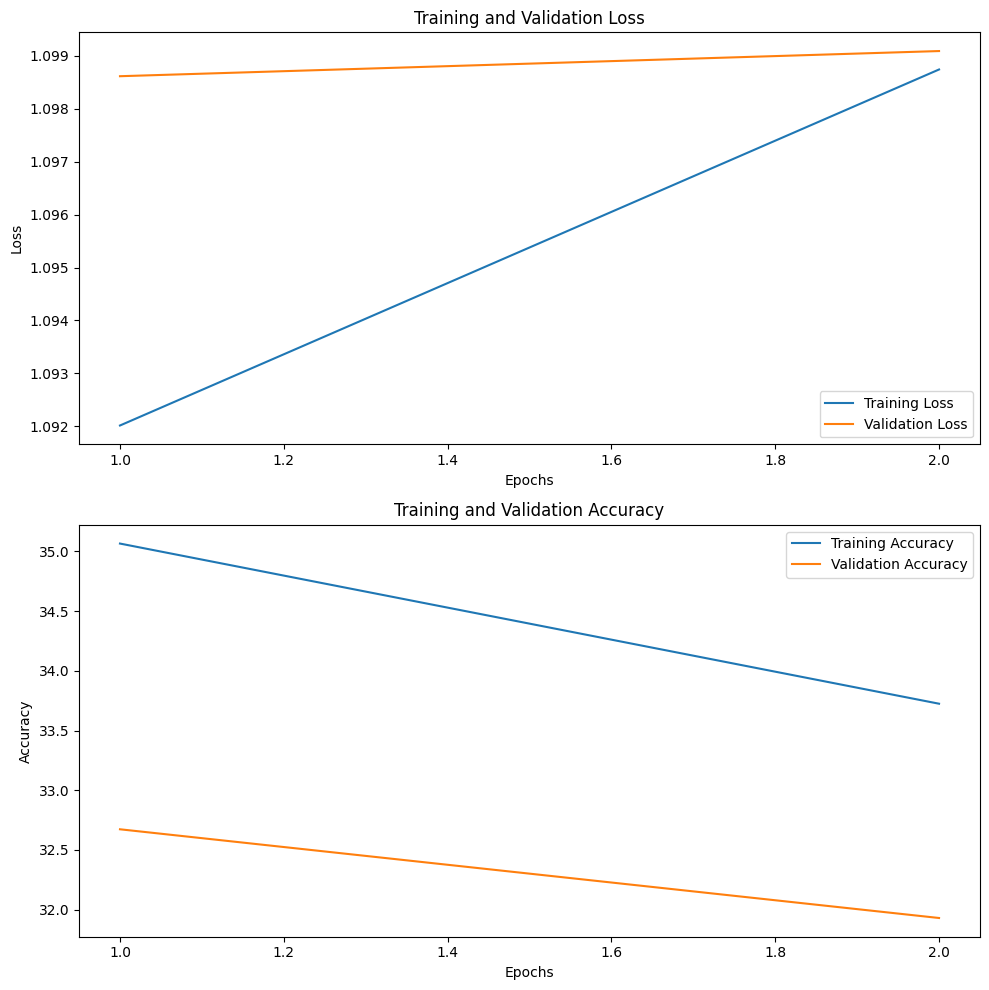

In [12]:
model = googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.2))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.1)

from torch.nn.utils import clip_grad_norm_
clip_value = 100.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [13]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 1.0986, Test Accuracy: 33.84%
Precision: 0.1128, Recall: 0.3333, F1 Score: 0.1686
Elapsed Time: 129.80 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah        0   359      0
Lion           0   375      0
Tiger          0   374      0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## AlexNet

#### Initializing

In [14]:
from torchvision.models import alexnet
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
from torchvision.datasets import ImageFolder

train_path = "/content/drive/MyDrive/Resubmission/TrainSet"
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

validation_path = "/content/drive/MyDrive/Resubmission/ValidationSet"
validation_dataset = ImageFolder(root=validation_path, transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)

test_path = "/content/drive/MyDrive/Resubmission/TestSet"
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

####Combination 1

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.1523, Train Accuracy: 33.26%, Validation Loss: 1.1206, Validation Accuracy: 34.16%
Elapsed Time: 27.02 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1409, Train Accuracy: 33.26%, Validation Loss: 1.1091, Validation Accuracy: 35.40%
Elapsed Time: 21.13 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.1169, Train Accuracy: 36.20%, Validation Loss: 1.0983, Validation Accuracy: 36.63%
Elapsed Time: 21.17 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.1203, Train Accuracy: 36.45%, Validation Loss: 1.0877, Validation Accuracy: 37.87%
Elapsed Time: 21.17 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.0985, Train Accuracy: 38.67%, Validation Loss: 1.0778, Validation Accuracy: 39.36%
Elapsed Time: 20.32 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.0913, Train Accuracy: 39.55%, Validation Loss: 

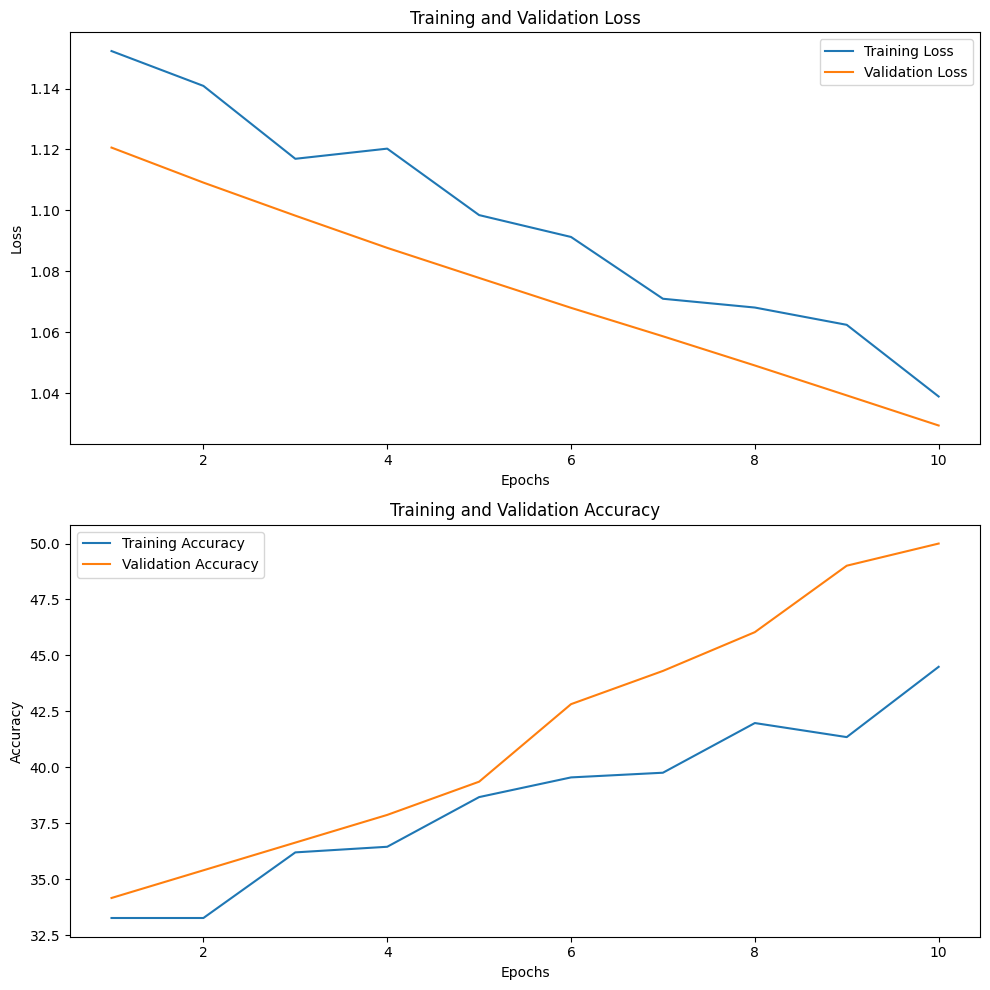

In [ ]:
model = alexnet(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.2))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 1.0218, Test Accuracy: 47.38%
Precision: 0.4552, Recall: 0.4763, F1 Score: 0.4447
Elapsed Time: 6.41 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      241    59     59
Lion          95   229     51
Tiger        229    90     55


####Combination 2

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 99.2MB/s]


Epoch 1, Train Loss: 0.5401, Train Accuracy: 71.18%, Validation Loss: 0.1726, Validation Accuracy: 94.31%
Elapsed Time: 300.13 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.4084, Train Accuracy: 76.75%, Validation Loss: 0.1621, Validation Accuracy: 93.32%
Elapsed Time: 293.80 seconds
--------------------------------------------------



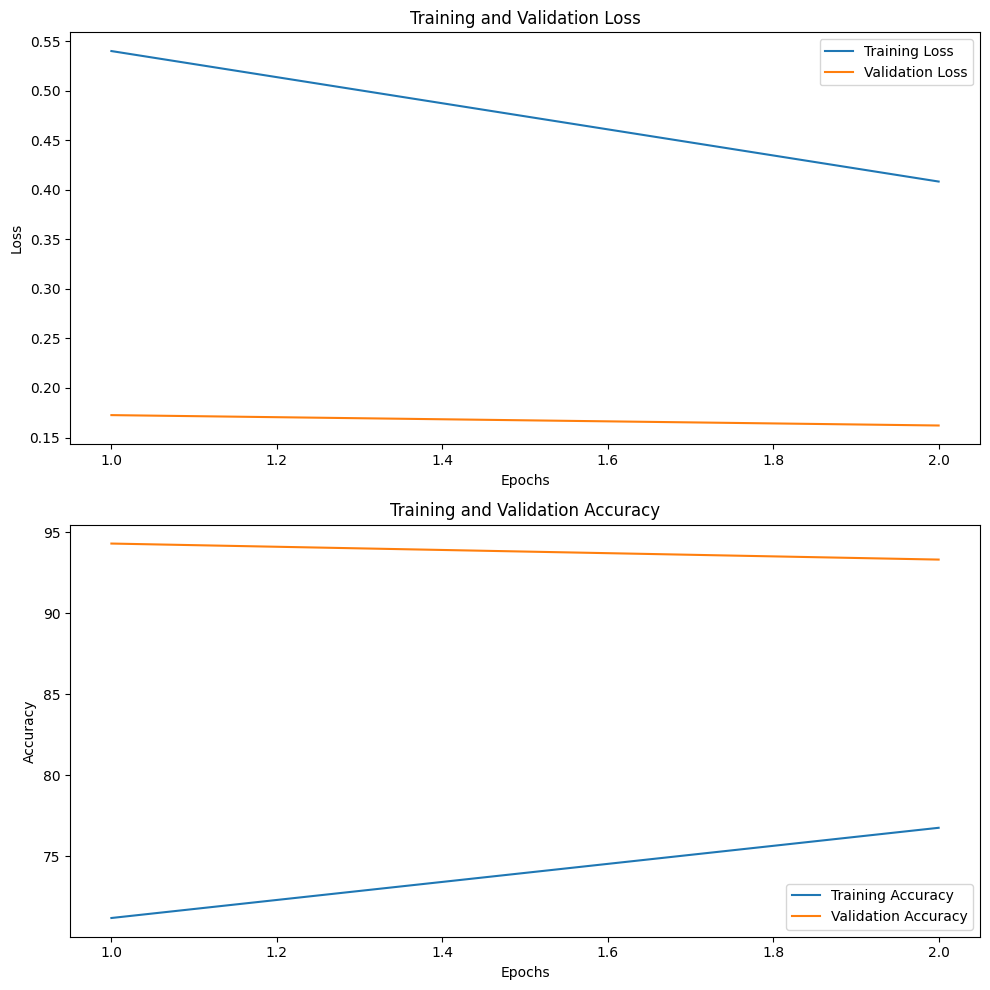

In [16]:
model = alexnet(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.3))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [17]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.1132, Test Accuracy: 96.30%
Precision: 0.9638, Recall: 0.9630, F1 Score: 0.9631
Elapsed Time: 43.45 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      347    12      0
Lion           7   365      3
Tiger          6    13    355


####Combination 3

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.7557, Train Accuracy: 56.68%, Validation Loss: 0.3003, Validation Accuracy: 90.35%
Elapsed Time: 303.76 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.5956, Train Accuracy: 65.52%, Validation Loss: 0.1744, Validation Accuracy: 94.55%
Elapsed Time: 289.26 seconds
--------------------------------------------------



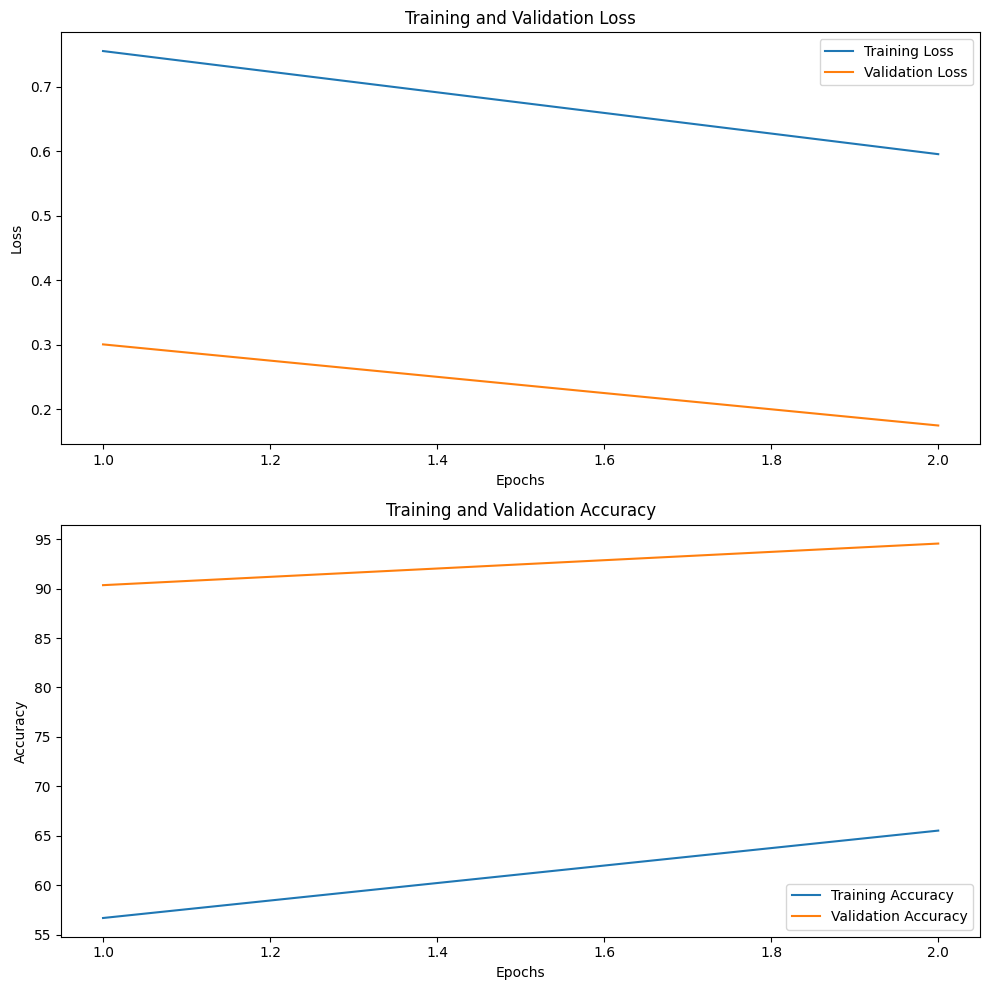

In [18]:
model = alexnet(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.5))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.01)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [19]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.1354, Test Accuracy: 96.66%
Precision: 0.9668, Recall: 0.9666, F1 Score: 0.9667
Elapsed Time: 43.66 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      348     9      2
Lion           5   362      8
Tiger          4     9    361


####Combination 4

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.7173, Train Accuracy: 59.70%, Validation Loss: 0.2263, Validation Accuracy: 93.07%
Elapsed Time: 326.07 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.5860, Train Accuracy: 66.02%, Validation Loss: 0.2236, Validation Accuracy: 92.82%
Elapsed Time: 291.01 seconds
--------------------------------------------------



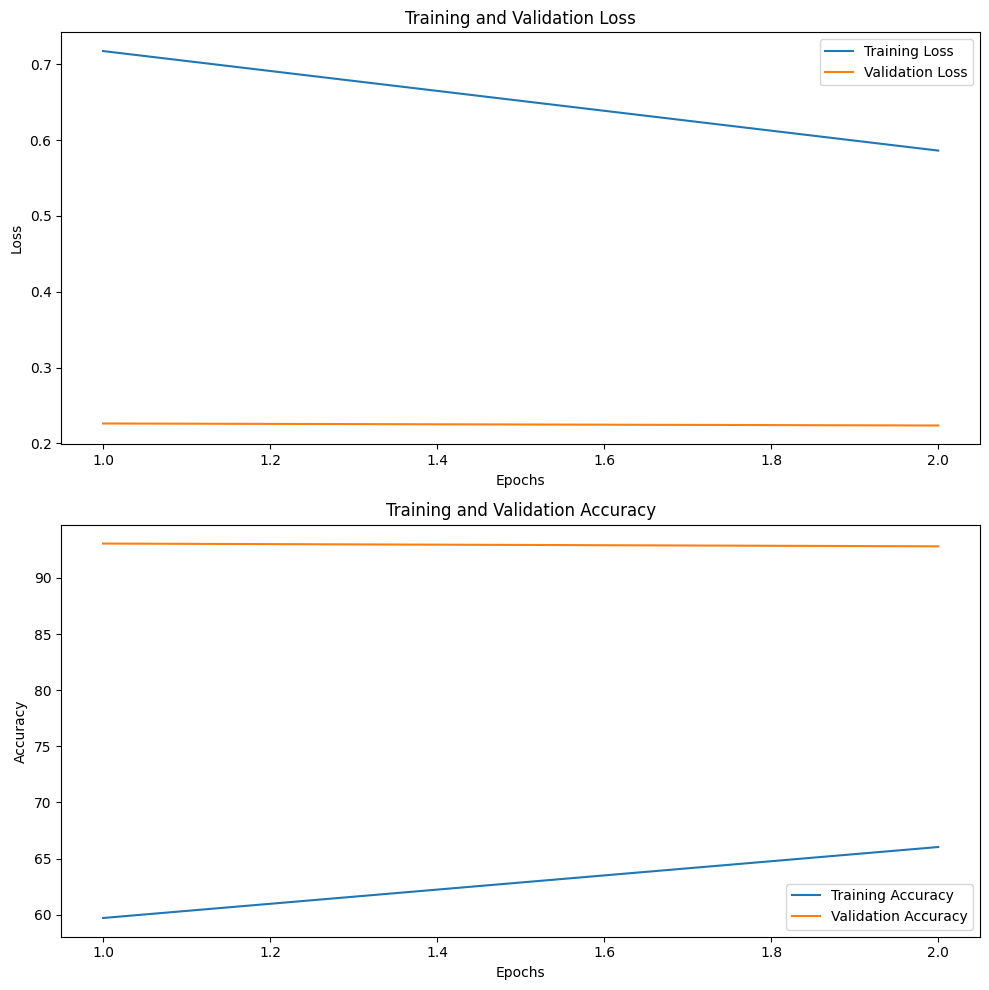

In [20]:
model = alexnet(pretrained=True)
model.classifier[6] = nn.Sequential(nn.Linear(4096, 3),nn.ReLU(inplace=True),nn.Dropout(0.5))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.01)

from torch.nn.utils import clip_grad_norm_
clip_value = 500.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [21]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.1685, Test Accuracy: 96.66%
Precision: 0.9669, Recall: 0.9668, F1 Score: 0.9666
Elapsed Time: 48.08 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      352     4      3
Lion          11   352     12
Tiger          7     0    367


## Resnet

####Initialization

In [4]:
from torchvision.models import resnet34
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from torchvision.datasets import ImageFolder

train_path = "/content/drive/MyDrive/Resubmission/TrainSet"
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

validation_path = "/content/drive/MyDrive/Resubmission/ValidationSet"
validation_dataset = ImageFolder(root=validation_path, transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)

test_path = "/content/drive/MyDrive/Resubmission/TestSet"
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

####Combination 1

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.1262, Train Accuracy: 35.40%, Validation Loss: 1.0830, Validation Accuracy: 39.36%
Elapsed Time: 31.86 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1192, Train Accuracy: 37.29%, Validation Loss: 1.0768, Validation Accuracy: 41.34%
Elapsed Time: 28.05 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.1031, Train Accuracy: 39.21%, Validation Loss: 1.0617, Validation Accuracy: 44.80%
Elapsed Time: 27.80 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.0905, Train Accuracy: 41.94%, Validation Loss: 1.0531, Validation Accuracy: 46.78%
Elapsed Time: 28.77 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.0795, Train Accuracy: 44.74%, Validation Loss: 1.0411, Validation Accuracy: 49.01%
Elapsed Time: 28.15 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.0733, Train Accuracy: 45.83%, Validation Loss: 

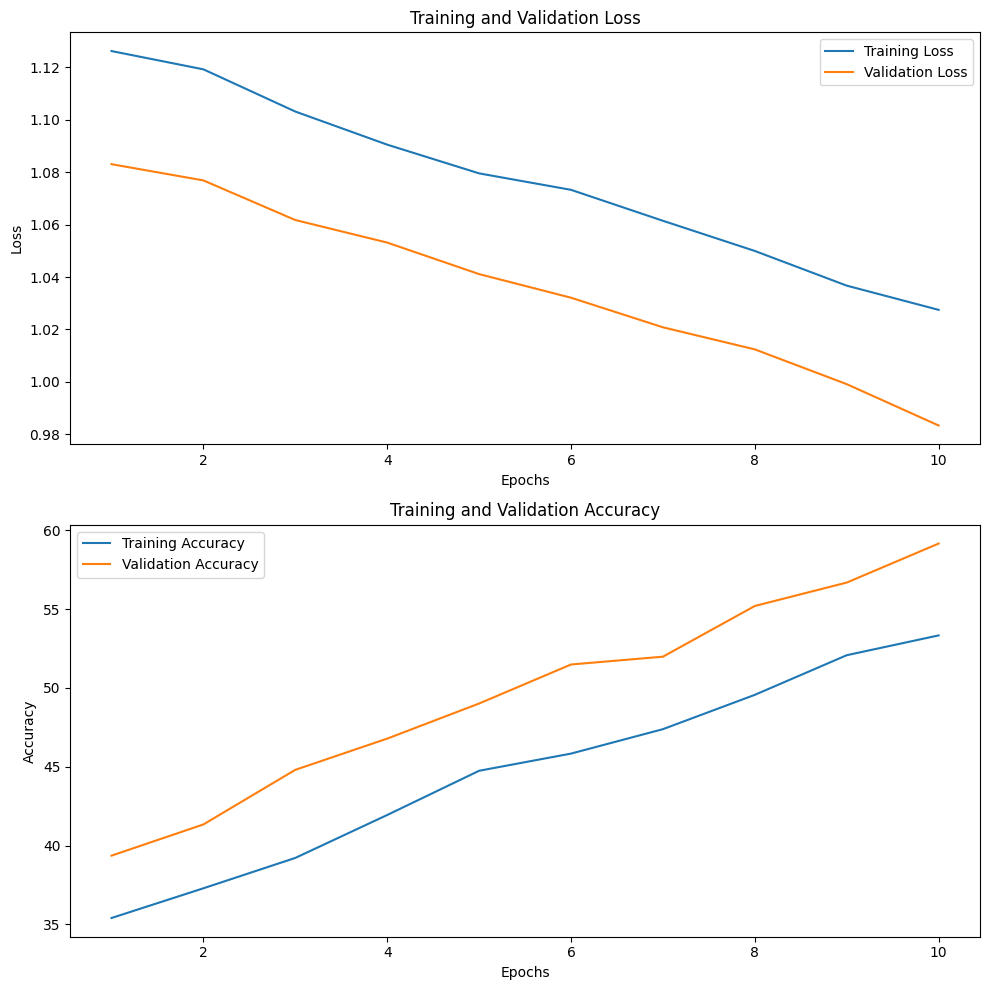

In [ ]:
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.2))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']

for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 1.0011, Test Accuracy: 57.94%
Precision: 0.6017, Recall: 0.5786, F1 Score: 0.5628
Elapsed Time: 8.30 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      180    70    109
Lion          63   140    172
Tiger         46     6    322


####Combination 2

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.2MB/s]


Epoch 1, Train Loss: 0.5978, Train Accuracy: 76.37%, Validation Loss: 0.2118, Validation Accuracy: 97.52%
Elapsed Time: 1652.03 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.2395, Train Accuracy: 91.29%, Validation Loss: 0.1174, Validation Accuracy: 98.27%
Elapsed Time: 28.06 seconds
--------------------------------------------------



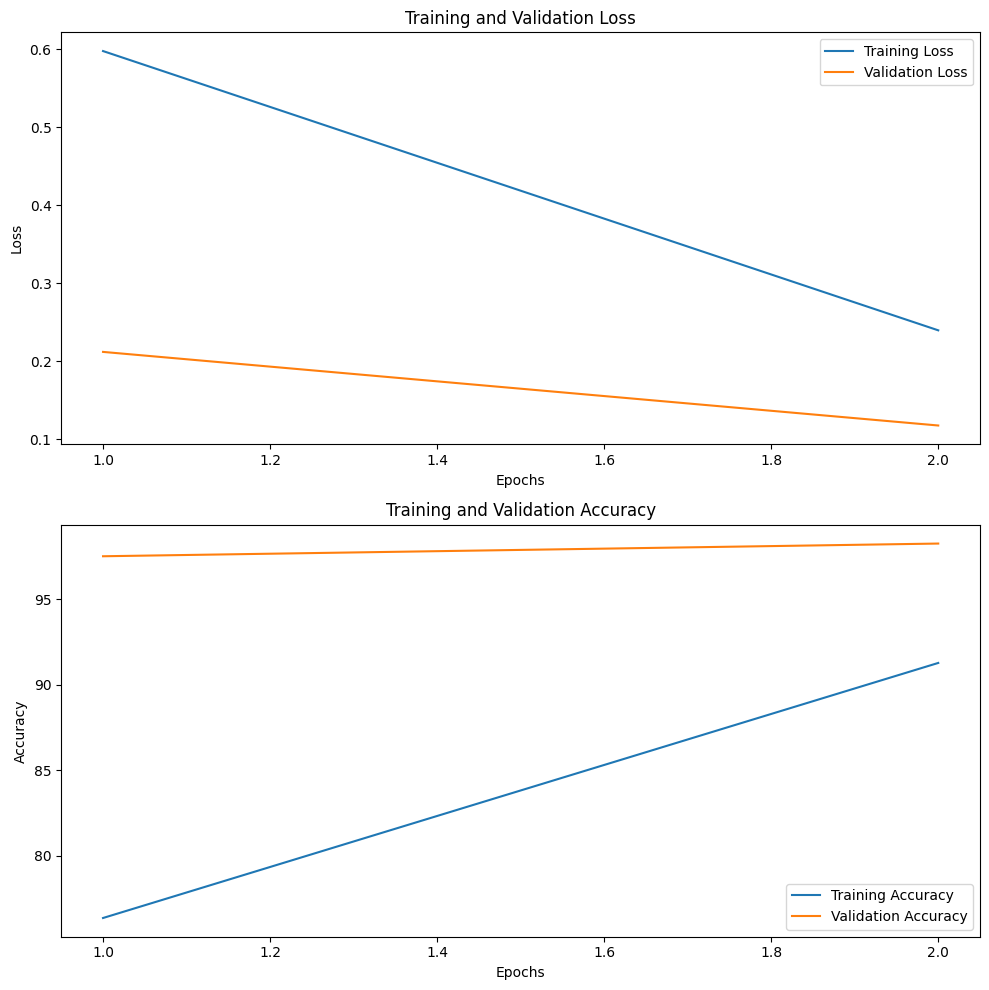

In [6]:
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.1))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

from torch.nn.utils import clip_grad_norm_
clip_value = 1000.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [7]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []
for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.0944, Test Accuracy: 98.92%
Precision: 0.9891, Recall: 0.9891, F1 Score: 0.9891
Elapsed Time: 918.09 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      354     4      1
Lion           2   371      2
Tiger          3     0    371


####Combination 3

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.4306, Train Accuracy: 76.87%, Validation Loss: 0.1354, Validation Accuracy: 95.05%
Elapsed Time: 27.58 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.3742, Train Accuracy: 79.64%, Validation Loss: 0.1149, Validation Accuracy: 97.52%
Elapsed Time: 27.43 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.3660, Train Accuracy: 78.84%, Validation Loss: 0.1064, Validation Accuracy: 96.53%
Elapsed Time: 27.44 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.3699, Train Accuracy: 79.26%, Validation Loss: 0.1187, Validation Accuracy: 96.78%
Elapsed Time: 27.52 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.3578, Train Accuracy: 79.01%, Validation Loss: 0.1133, Validation Accuracy: 97.28%
Elapsed Time: 27.54 seconds
--------------------------------------------------

Epoch 6, Train Loss: 0.3705, Train Accuracy: 78.38%, Validation Loss: 

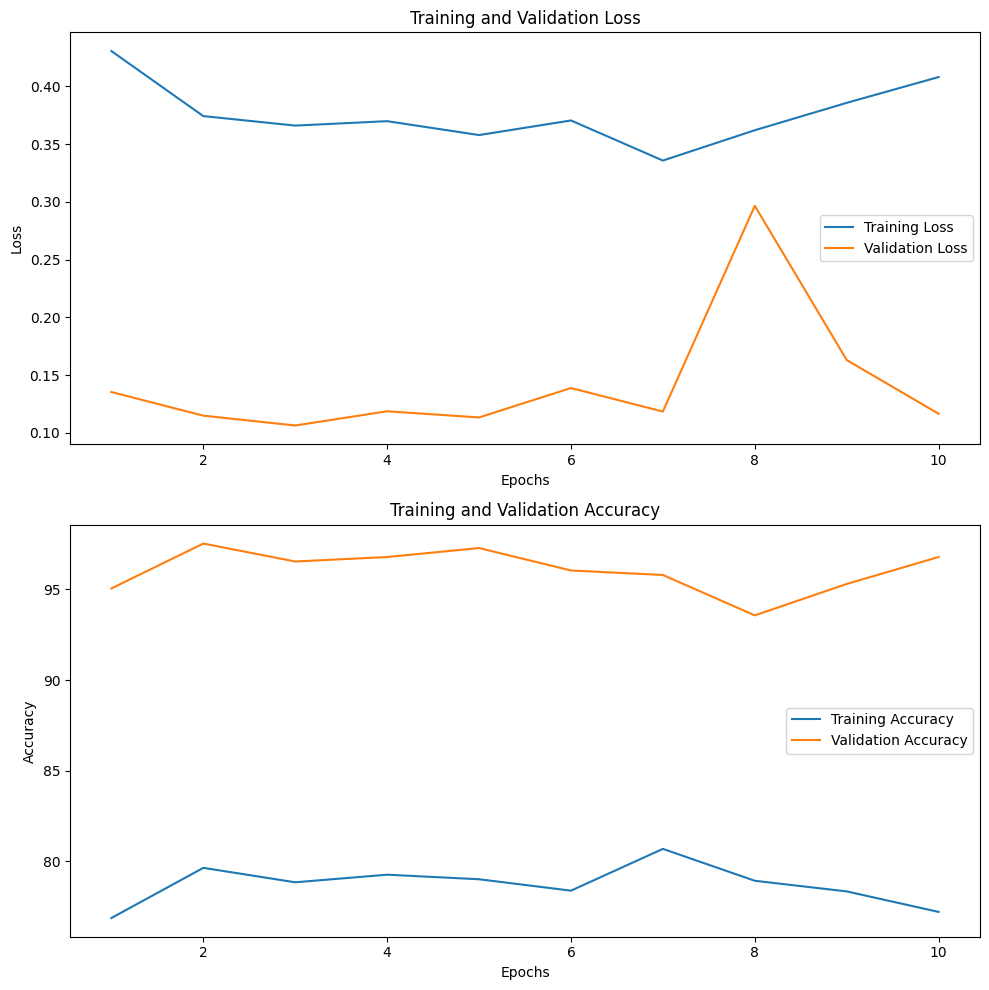

In [8]:
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.3))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

from torch.nn.utils import clip_grad_norm_
clip_value = 800.0

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [9]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []
for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 0.0996, Test Accuracy: 97.29%
Precision: 0.9735, Recall: 0.9730, F1 Score: 0.9730
Elapsed Time: 8.00 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      351     7      1
Lion           4   369      2
Tiger          4    12    358


####Combination 4

Training/Validation Result

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.0280, Train Accuracy: 41.98%, Validation Loss: 1.5925, Validation Accuracy: 48.02%
Elapsed Time: 37.00 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1021, Train Accuracy: 35.06%, Validation Loss: 1.0987, Validation Accuracy: 32.67%
Elapsed Time: 32.82 seconds
--------------------------------------------------



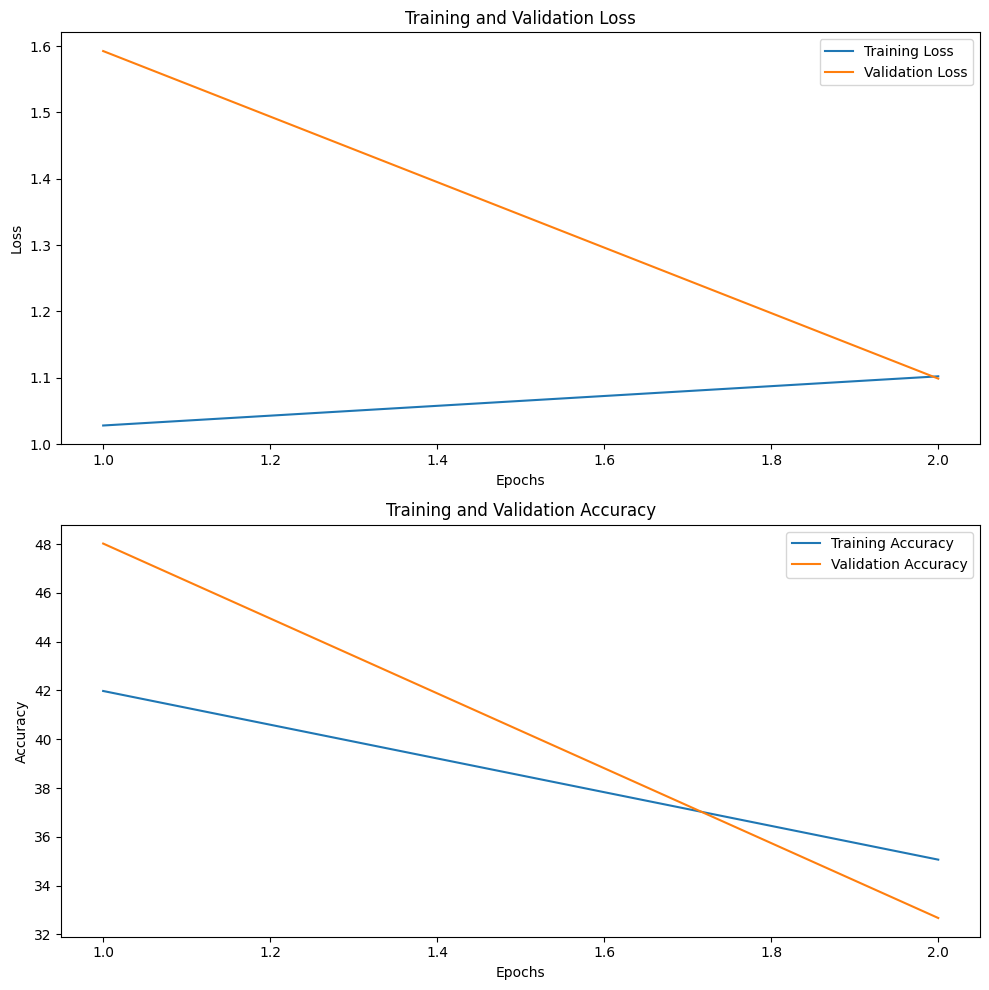

In [10]:
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 3), nn.ReLU(inplace=True),nn.Dropout(p=0.7))
model = model.to(device) # Move the model to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.1)

from torch.nn.utils import clip_grad_norm_
clip_value = 500.0

num_epochs = 2
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training -----------------------------------------------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation -------------------------------------------------------------------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(validation_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Testing Result

In [11]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import pandas as pd

class_names = ['Cheetah', 'Lion', 'Tiger']
test_losses = []
for epoch in range(num_epochs - num_epochs + 1):
    start_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    end_time = time.time()
    elapsed_time = end_time - start_time


    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(conf_matrix_with_labels)

Epoch 1, Test Loss: 1.0989, Test Accuracy: 32.40%
Precision: 0.1080, Recall: 0.3333, F1 Score: 0.1631
Elapsed Time: 7.90 seconds
--------------------------------------------------

Confusion Matrix:
         Cheetah  Lion  Tiger
Cheetah      359     0      0
Lion         375     0      0
Tiger        374     0      0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
